# Transfer Learning - Comprehensive Guide for Exam Preparation

This notebook provides a complete understanding of Transfer Learning techniques covering:
- Mathematical foundations and concepts
- Pre-trained model architectures (ResNet, VGG, EfficientNet)
- Feature extraction vs fine-tuning strategies
- Custom dataset implementation
- Advanced techniques and optimizations
- Real-world applications and case studies

**Key Exam Topics Covered:**
- Transfer learning principles and motivation
- Pre-trained model architectures
- Layer freezing and unfreezing strategies
- Learning rate scheduling for transfer learning
- Domain adaptation techniques
- Few-shot learning applications
- Model evaluation and interpretation

### Why Transfer Learning?

1. **Reduced Training Time**: Start with pre-trained weights
2. **Better Performance**: Leverage learned features
3. **Less Data Required**: Effective with small datasets
4. **Computational Efficiency**: Avoid training from scratch

## 1. Import Required Libraries and Setup

In [1]:
# Essential libraries for transfer learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder

# Pre-trained models
from torchvision.models import (
    resnet18, resnet34, resnet50, resnet101,
    vgg16, vgg19,
    efficientnet_b0, efficientnet_b1,
    mobilenet_v2, densenet121
)

# Numerical computing and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Utilities
import time
import os
import copy
import random
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# For model evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Matplotlib settings
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Available pre-trained models: ResNet, VGG, EfficientNet, MobileNet, DenseNet")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090
Memory: 23.6 GB
✅ All libraries imported successfully!
PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
Available pre-trained models: ResNet, VGG, EfficientNet, MobileNet, DenseNet


## 2. Understanding Transfer Learning Concepts

### Mathematical Foundation

Transfer learning leverages knowledge from a source task to improve performance on a target task. Mathematically:

**Source Domain**: $D_s = \{X_s, P(X_s)\}$ where $X_s$ is feature space and $P(X_s)$ is marginal probability
**Target Domain**: $D_t = \{X_t, P(X_t)\}$

**Source Task**: $T_s = \{Y_s, f_s(·)\}$ where $Y_s$ is label space and $f_s$ is predictive function
**Target Task**: $T_t = \{Y_t, f_t(·)\}$

### Key Strategies:

1. **Feature Extraction**: Freeze pre-trained weights, train only classifier
   - $\theta_{pretrained}$ remains fixed
   - Only $\theta_{classifier}$ is updated

2. **Fine-tuning**: Update entire network with small learning rates
   - All parameters updated: $\theta = \theta_{pretrained} + \Delta\theta$
   - Lower learning rates for early layers

3. **Progressive Unfreezing**: Gradually unfreeze layers during training

### When to Use Each Strategy:

| Dataset Size | Similarity to Pre-trained | Strategy |
|--------------|---------------------------|----------|
| Small | High | Feature Extraction |
| Small | Low | Fine-tune top layers |
| Large | High | Fine-tune entire network |
| Large | Low | Train from scratch or fine-tune |

Loading pre-trained ResNet18 model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.1MB/s]



Original model structure (last few layers):
Average pooling: AdaptiveAvgPool2d(output_size=(1, 1))
Final classifier: Linear(in_features=512, out_features=10, bias=True)

Feature Extraction Model Layer Analysis:
Total parameters: 11,181,642
Trainable parameters: 5,130
Frozen parameters: 11,176,512
Trainable ratio: 0.05%

Layer-wise parameter status:
------------------------------
conv1.weight                   |    9,408 params | ✗ Frozen
bn1.weight                     |       64 params | ✗ Frozen
bn1.bias                       |       64 params | ✗ Frozen
layer1.0.conv1.weight          |   36,864 params | ✗ Frozen
layer1.0.bn1.weight            |       64 params | ✗ Frozen
layer1.0.bn1.bias              |       64 params | ✗ Frozen
layer1.0.conv2.weight          |   36,864 params | ✗ Frozen
layer1.0.bn2.weight            |       64 params | ✗ Frozen
layer1.0.bn2.bias              |       64 params | ✗ Frozen
layer1.1.conv1.weight          |   36,864 params | ✗ Frozen
layer1.1.bn1.weigh

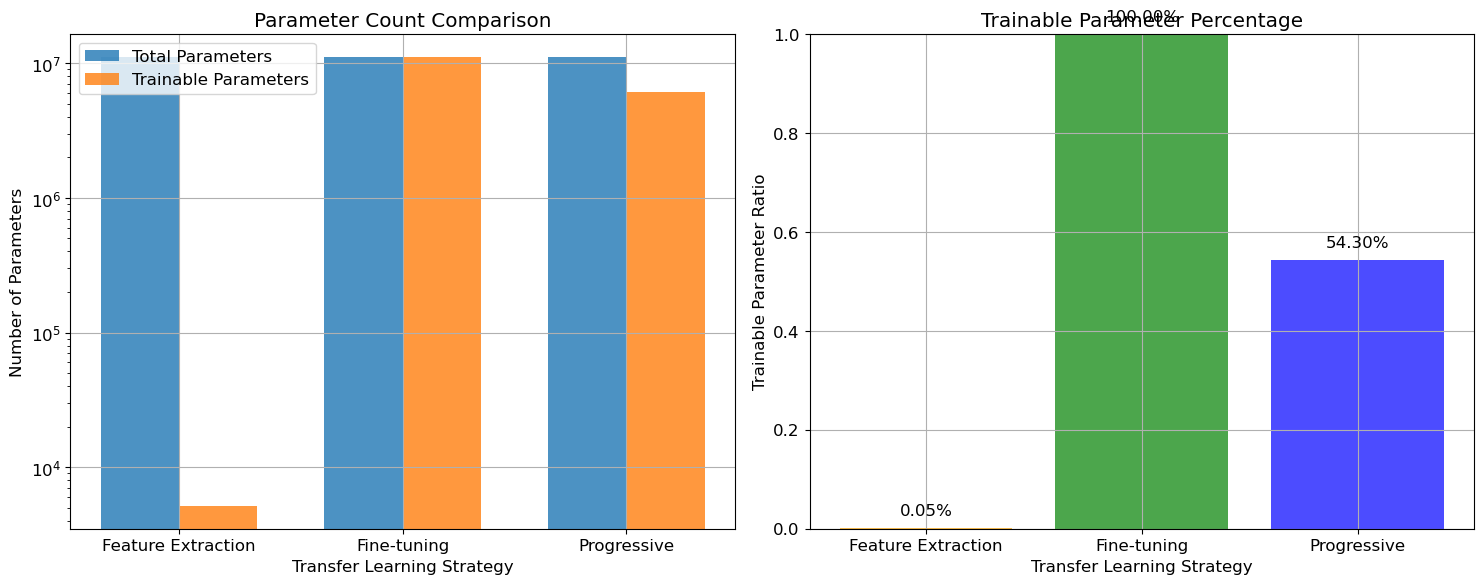


✅ Transfer learning concepts demonstrated!

Key Takeaways:
• Feature extraction: Only classifier is trainable (~0.1% of parameters)
• Fine-tuning: All parameters are trainable (100% of parameters)
• Progressive: Selective layer freezing (balanced approach)


In [2]:
# Transfer Learning Concept Demonstrations

class TransferLearningAnalyzer:
    """Utility class to analyze transfer learning approaches."""
    
    def __init__(self):
        self.results = {}
    
    def count_parameters(self, model):
        """Count total and trainable parameters."""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return total_params, trainable_params
    
    def freeze_layers(self, model, freeze_until_layer=None):
        """Freeze model parameters until specified layer."""
        if freeze_until_layer is None:
            # Freeze all layers except the last (classifier)
            for name, param in model.named_parameters():
                if 'classifier' not in name and 'fc' not in name:
                    param.requires_grad = False
        else:
            # Freeze until specific layer
            layer_count = 0
            for name, param in model.named_parameters():
                if layer_count < freeze_until_layer:
                    param.requires_grad = False
                layer_count += 1
    
    def unfreeze_layers(self, model, unfreeze_from_layer=None):
        """Unfreeze model parameters from specified layer."""
        if unfreeze_from_layer is None:
            # Unfreeze all layers
            for param in model.parameters():
                param.requires_grad = True
        else:
            # Unfreeze from specific layer
            layer_count = 0
            for name, param in model.named_parameters():
                if layer_count >= unfreeze_from_layer:
                    param.requires_grad = True
                layer_count += 1
    
    def analyze_model_layers(self, model, model_name="Model"):
        """Analyze and display model layer information."""
        print(f"\n{model_name} Layer Analysis:")
        print("=" * 50)
        
        total_params, trainable_params = self.count_parameters(model)
        frozen_params = total_params - trainable_params
        
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Frozen parameters: {frozen_params:,}")
        print(f"Trainable ratio: {trainable_params/total_params:.2%}")
        
        print("\nLayer-wise parameter status:")
        print("-" * 30)
        for name, param in model.named_parameters():
            status = "✓ Trainable" if param.requires_grad else "✗ Frozen"
            print(f"{name:30} | {param.numel():>8,} params | {status}")
        
        return total_params, trainable_params

# Demonstrate different transfer learning strategies
analyzer = TransferLearningAnalyzer()

# Load a pre-trained ResNet18 model
print("Loading pre-trained ResNet18 model...")
pretrained_model = resnet18(pretrained=True)

# Modify the final layer for our target task (10 classes)
num_classes = 10
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

print(f"Original model structure (last few layers):")
print(f"Average pooling: {pretrained_model.avgpool}")
print(f"Final classifier: {pretrained_model.fc}")

# Strategy 1: Feature Extraction (freeze all except classifier)
feature_extractor = copy.deepcopy(pretrained_model)
analyzer.freeze_layers(feature_extractor)
analyzer.analyze_model_layers(feature_extractor, "Feature Extraction Model")

# Strategy 2: Fine-tuning (all layers trainable)
fine_tuner = copy.deepcopy(pretrained_model)
analyzer.unfreeze_layers(fine_tuner)
analyzer.analyze_model_layers(fine_tuner, "Fine-tuning Model")

# Strategy 3: Progressive unfreezing (freeze early layers)
progressive_model = copy.deepcopy(pretrained_model)
# Freeze first 3 layer groups, keep later layers trainable
for name, param in progressive_model.named_parameters():
    if any(layer in name for layer in ['conv1', 'bn1', 'layer1', 'layer2']):
        param.requires_grad = False
analyzer.analyze_model_layers(progressive_model, "Progressive Unfreezing Model")

# Visualize parameter distribution
def plot_parameter_comparison():
    """Plot parameter statistics for different strategies."""
    strategies = ['Feature Extraction', 'Fine-tuning', 'Progressive']
    
    # Get parameter counts
    models = [feature_extractor, fine_tuner, progressive_model]
    total_params = []
    trainable_params = []
    
    for model in models:
        total, trainable = analyzer.count_parameters(model)
        total_params.append(total)
        trainable_params.append(trainable)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Parameter counts
    x = np.arange(len(strategies))
    width = 0.35
    
    ax1.bar(x - width/2, total_params, width, label='Total Parameters', alpha=0.8)
    ax1.bar(x + width/2, trainable_params, width, label='Trainable Parameters', alpha=0.8)
    ax1.set_xlabel('Transfer Learning Strategy')
    ax1.set_ylabel('Number of Parameters')
    ax1.set_title('Parameter Count Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(strategies)
    ax1.legend()
    ax1.set_yscale('log')
    
    # Trainable ratio
    trainable_ratios = [t/total for t, total in zip(trainable_params, total_params)]
    ax2.bar(strategies, trainable_ratios, color=['orange', 'green', 'blue'], alpha=0.7)
    ax2.set_xlabel('Transfer Learning Strategy')
    ax2.set_ylabel('Trainable Parameter Ratio')
    ax2.set_title('Trainable Parameter Percentage')
    ax2.set_ylim(0, 1)
    
    # Add percentage labels
    for i, ratio in enumerate(trainable_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_parameter_comparison()

print("\n✅ Transfer learning concepts demonstrated!")
print("\nKey Takeaways:")
print("• Feature extraction: Only classifier is trainable (~0.1% of parameters)")
print("• Fine-tuning: All parameters are trainable (100% of parameters)")
print("• Progressive: Selective layer freezing (balanced approach)")

## 3. Preparing Pre-trained Models

### Popular Pre-trained Architectures:

1. **ResNet Family**: Deep residual networks with skip connections
   - ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
   - Training: ImageNet (1000 classes, 1.2M images)

2. **VGG Family**: Very deep networks with small filters
   - VGG16, VGG19
   - Simple architecture, good for feature extraction

3. **EfficientNet**: Compound scaling of depth, width, resolution
   - EfficientNet-B0 to B7
   - Best accuracy-efficiency trade-off

4. **MobileNet**: Lightweight models for mobile deployment
   - Depthwise separable convolutions
   - Good for resource-constrained environments

### Model Modification Steps:

1. Load pre-trained model
2. Analyze architecture
3. Modify final layer(s) for target task
4. Choose freezing strategy
5. Set appropriate learning rates

Loading Pre-trained Models...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.7MB/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  0%|          | 0.00/97.8M [00:00<?, ?B/s]Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.3MB/s]



✅ ResNet models loaded


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 92.1MB/s] 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
  0%|          | 0.00/548M [00:00<?, ?B/s]Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.6MB/s] 

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


✅ VGG models loaded


100%|██████████| 20.5M/20.5M [00:00<00:00, 69.2MB/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
  0%|          | 0.00/30.1M [00:00<?, ?B/s]Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 79.9MB/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/jovyan/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/jovyan/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


✅ EfficientNet models loaded


100%|██████████| 13.6M/13.6M [00:00<00:00, 37.3MB/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
  0%|          | 0.00/30.8M [00:00<?, ?B/s]Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 81.5MB/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 81.5MB/s]


✅ Lightweight models loaded

ResNet18 Architecture Analysis:
Total parameters: 11,181,642
Feature extractor: ResNet18 backbone
Final layer: Linear(512 → 10)
Approximate model size: 42.7 MB

ResNet34 Architecture Analysis:
Total parameters: 21,289,802
Feature extractor: ResNet34 backbone
Final layer: Linear(512 → 10)
Approximate model size: 81.2 MB

ResNet50 Architecture Analysis:
Total parameters: 23,528,522
Feature extractor: ResNet50 backbone
Final layer: Linear(2048 → 10)
Approximate model size: 89.8 MB

VGG16 Architecture Analysis:
Total parameters: 134,301,514
Feature extractor: VGG16 backbone
Classifier: Sequential with 7 layers
Final layer: Linear(in_features=4096, out_features=10, bias=True)
Approximate model size: 512.3 MB

VGG19 Architecture Analysis:
Total parameters: 139,611,210
Feature extractor: VGG19 backbone
Classifier: Sequential with 7 layers
Final layer: Linear(in_features=4096, out_features=10, bias=True)
Approximate model size: 532.6 MB

EfficientNet-B0 Architectur

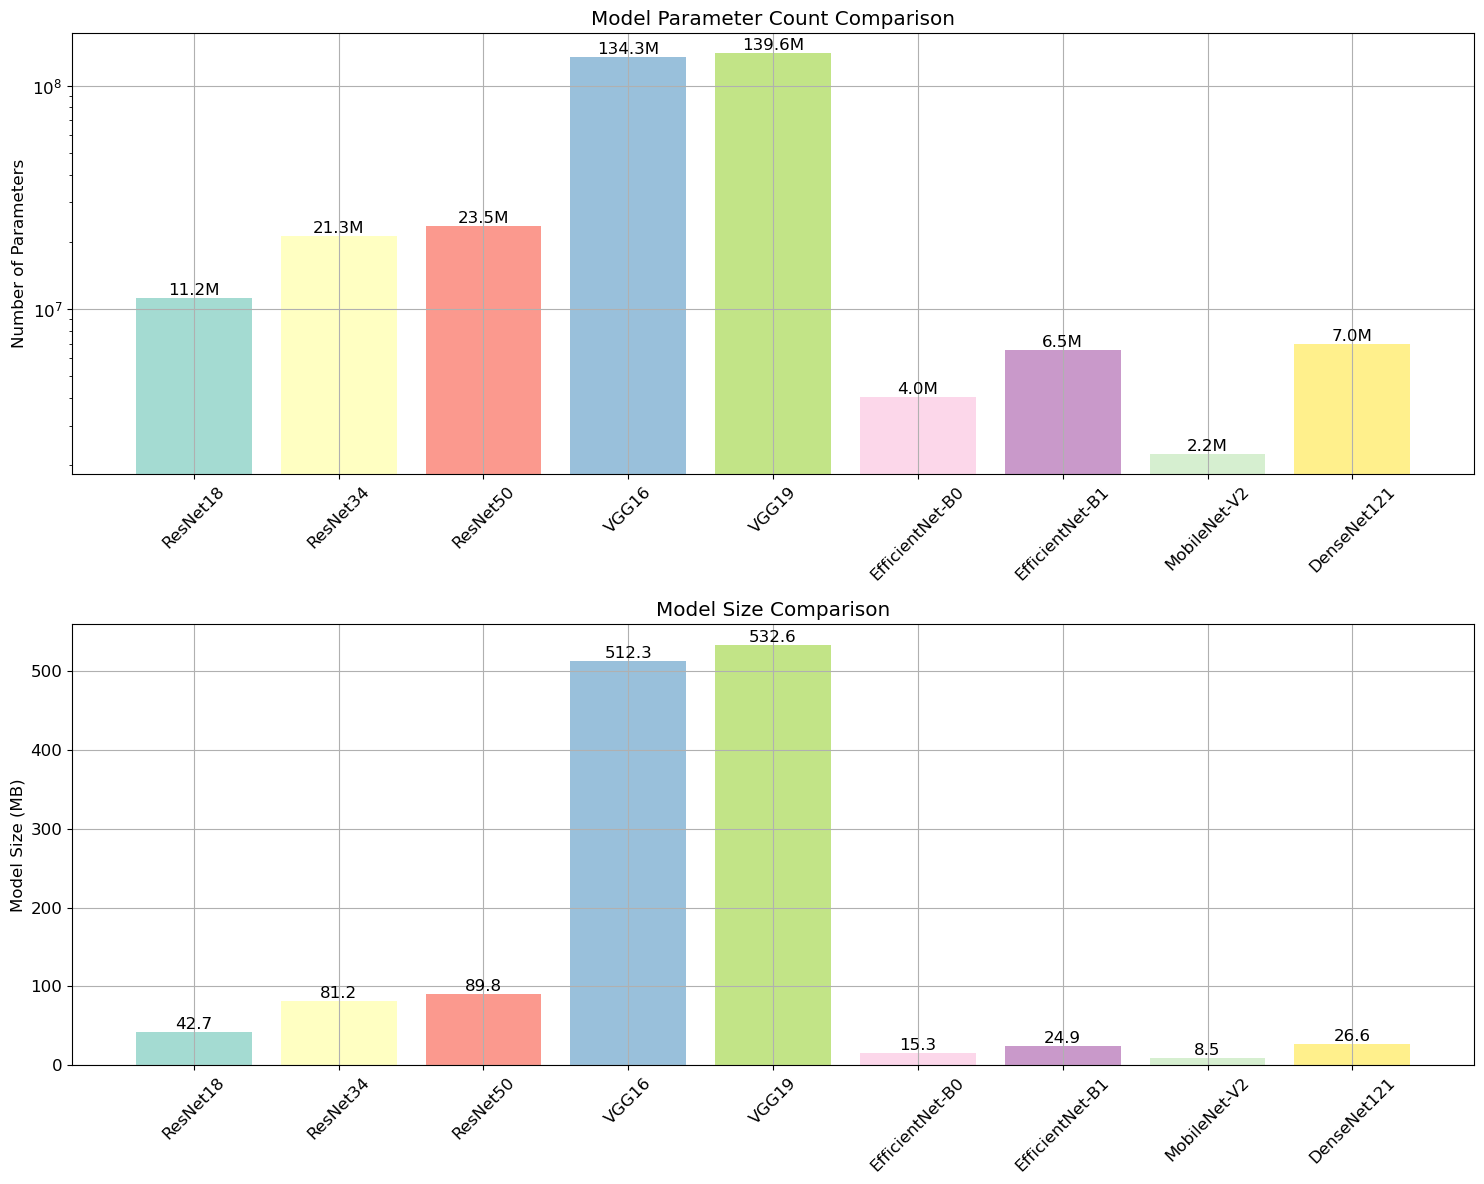


MODEL SELECTION GUIDELINES

📊 Parameter Count Ranking:
1. MobileNet-V2    |    2.2M parameters |   8.5 MB
2. EfficientNet-B0 |    4.0M parameters |  15.3 MB
3. EfficientNet-B1 |    6.5M parameters |  24.9 MB
4. DenseNet121     |    7.0M parameters |  26.6 MB
5. ResNet18        |   11.2M parameters |  42.7 MB
6. ResNet34        |   21.3M parameters |  81.2 MB
7. ResNet50        |   23.5M parameters |  89.8 MB
8. VGG16           |  134.3M parameters | 512.3 MB
9. VGG19           |  139.6M parameters | 532.6 MB

🎯 Recommendations:
• Small dataset (< 1K images): MobileNet-V2 or EfficientNet-B0
• Medium dataset (1K-10K): ResNet18 or ResNet34
• Large dataset (> 10K): ResNet50 or EfficientNet-B1
• Mobile deployment: MobileNet-V2
• High accuracy priority: EfficientNet-B1 or ResNet50
• Fast training: ResNet18

✅ Pre-trained models prepared and analyzed!


In [3]:
# Comprehensive Pre-trained Model Preparation

class PretrainedModelManager:
    """Manager class for loading and preparing pre-trained models."""
    
    def __init__(self, num_classes=10):
        self.num_classes = num_classes
        self.models = {}
    
    def load_resnet_models(self):
        """Load ResNet family models."""
        resnet_models = {
            'ResNet18': resnet18(pretrained=True),
            'ResNet34': resnet34(pretrained=True),
            'ResNet50': resnet50(pretrained=True),
        }
        
        for name, model in resnet_models.items():
            # Modify final layer
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
            self.models[name] = model
        
        return resnet_models
    
    def load_vgg_models(self):
        """Load VGG family models."""
        vgg_models = {
            'VGG16': vgg16(pretrained=True),
            'VGG19': vgg19(pretrained=True),
        }
        
        for name, model in vgg_models.items():
            # Modify classifier
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, self.num_classes)
            self.models[name] = model
        
        return vgg_models
    
    def load_efficientnet_models(self):
        """Load EfficientNet family models."""
        efficientnet_models = {
            'EfficientNet-B0': efficientnet_b0(pretrained=True),
            'EfficientNet-B1': efficientnet_b1(pretrained=True),
        }
        
        for name, model in efficientnet_models.items():
            # Modify classifier
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
            self.models[name] = model
        
        return efficientnet_models
    
    def load_lightweight_models(self):
        """Load lightweight models for mobile deployment."""
        lightweight_models = {
            'MobileNet-V2': mobilenet_v2(pretrained=True),
            'DenseNet121': densenet121(pretrained=True),
        }
        
        # Modify MobileNet
        lightweight_models['MobileNet-V2'].classifier[1] = nn.Linear(
            lightweight_models['MobileNet-V2'].classifier[1].in_features, 
            self.num_classes
        )
        
        # Modify DenseNet
        lightweight_models['DenseNet121'].classifier = nn.Linear(
            lightweight_models['DenseNet121'].classifier.in_features, 
            self.num_classes
        )
        
        for name, model in lightweight_models.items():
            self.models[name] = model
        
        return lightweight_models
    
    def analyze_model_architecture(self, model, model_name):
        """Analyze and display model architecture details."""
        total_params = sum(p.numel() for p in model.parameters())
        
        print(f"\n{model_name} Architecture Analysis:")
        print("=" * 50)
        print(f"Total parameters: {total_params:,}")
        
        # Get model structure info
        if hasattr(model, 'fc'):  # ResNet style
            print(f"Feature extractor: {model_name.split('-')[0]} backbone")
            print(f"Final layer: Linear({model.fc.in_features} → {model.fc.out_features})")
        elif hasattr(model, 'classifier'):  # VGG/EfficientNet style
            print(f"Feature extractor: {model_name.split('-')[0]} backbone")
            if isinstance(model.classifier, nn.Sequential):
                print(f"Classifier: Sequential with {len(model.classifier)} layers")
                print(f"Final layer: {model.classifier[-1]}")
            else:
                print(f"Classifier: {model.classifier}")
        
        # Calculate model size (approximate)
        model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32
        print(f"Approximate model size: {model_size_mb:.1f} MB")
        
        return total_params, model_size_mb

# Initialize model manager
manager = PretrainedModelManager(num_classes=10)

# Load different model families
print("Loading Pre-trained Models...")
print("=" * 40)

# Load ResNet models
resnet_models = manager.load_resnet_models()
print("✅ ResNet models loaded")

# Load VGG models
vgg_models = manager.load_vgg_models()
print("✅ VGG models loaded")

# Load EfficientNet models
efficientnet_models = manager.load_efficientnet_models()
print("✅ EfficientNet models loaded")

# Load lightweight models
lightweight_models = manager.load_lightweight_models()
print("✅ Lightweight models loaded")

# Comprehensive model analysis
all_models = {**resnet_models, **vgg_models, **efficientnet_models, **lightweight_models}

model_stats = []
for name, model in all_models.items():
    total_params, size_mb = manager.analyze_model_architecture(model, name)
    model_stats.append({
        'Model': name,
        'Parameters': total_params,
        'Size (MB)': size_mb
    })

# Create comparison visualization
def plot_model_comparison():
    """Plot model comparison charts."""
    models = [stat['Model'] for stat in model_stats]
    parameters = [stat['Parameters'] for stat in model_stats]
    sizes = [stat['Size (MB)'] for stat in model_stats]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Parameter count comparison
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    bars1 = ax1.bar(models, parameters, color=colors, alpha=0.8)
    ax1.set_ylabel('Number of Parameters')
    ax1.set_title('Model Parameter Count Comparison')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_yscale('log')
    
    # Add value labels on bars
    for bar, param in zip(bars1, parameters):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{param/1e6:.1f}M', ha='center', va='bottom')
    
    # Model size comparison
    bars2 = ax2.bar(models, sizes, color=colors, alpha=0.8)
    ax2.set_ylabel('Model Size (MB)')
    ax2.set_title('Model Size Comparison')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, size in zip(bars2, sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()

# Model selection guidelines
print("\n" + "=" * 50)
print("MODEL SELECTION GUIDELINES")
print("=" * 50)

print("\n📊 Parameter Count Ranking:")
sorted_stats = sorted(model_stats, key=lambda x: x['Parameters'])
for i, stat in enumerate(sorted_stats, 1):
    print(f"{i}. {stat['Model']:15} | {stat['Parameters']/1e6:6.1f}M parameters | {stat['Size (MB)']:5.1f} MB")

print("\n🎯 Recommendations:")
print("• Small dataset (< 1K images): MobileNet-V2 or EfficientNet-B0")
print("• Medium dataset (1K-10K): ResNet18 or ResNet34")
print("• Large dataset (> 10K): ResNet50 or EfficientNet-B1")
print("• Mobile deployment: MobileNet-V2")
print("• High accuracy priority: EfficientNet-B1 or ResNet50")
print("• Fast training: ResNet18")

print("\n✅ Pre-trained models prepared and analyzed!")

## 4. Feature Extraction Approach

### Concept
Feature extraction treats the pre-trained CNN as a **fixed feature extractor**:
- Freeze all convolutional layers
- Only train the final classifier
- Fast training with minimal computational resources
- Works well when target dataset is similar to ImageNet

### Mathematical Representation
Given pre-trained features $\phi(x; \theta_{pretrained})$:
- $\theta_{pretrained}$ remains frozen
- Only optimize classifier parameters: $\theta_{classifier}$
- $\hat{y} = f_{classifier}(\phi(x; \theta_{pretrained}); \theta_{classifier})$

### Advantages:
- **Fast Training**: Only a few parameters to optimize
- **Low Memory**: Reduced gradient computation
- **Stable**: Less prone to overfitting
- **Good Baseline**: Often achieves reasonable performance

### Disadvantages:
- **Limited Adaptation**: Cannot adapt features to new domain
- **Feature Mismatch**: May not work well for very different domains

Feature Extraction Transfer Learning Demo

📊 Analyzing RESNET18:
------------------------------
Total parameters: 11,181,642
Trainable parameters: 5,130
Frozen parameters: 11,176,512
Trainable ratio: 0.0005 (0.05%)

📊 Analyzing VGG16:
------------------------------
Total parameters: 134,301,514
Trainable parameters: 119,586,826
Frozen parameters: 14,714,688
Trainable ratio: 0.8904 (89.04%)

📊 Analyzing EFFICIENTNET_B0:
------------------------------
Total parameters: 4,020,358
Trainable parameters: 12,810
Frozen parameters: 4,007,548
Trainable ratio: 0.0032 (0.32%)

🚀 Quick Training Demo (Feature Extraction)
Total parameters: 134,301,514
Trainable parameters: 119,586,826
Frozen parameters: 14,714,688
Trainable ratio: 0.8904 (89.04%)

📊 Analyzing EFFICIENTNET_B0:
------------------------------
Total parameters: 4,020,358
Trainable parameters: 12,810
Frozen parameters: 4,007,548
Trainable ratio: 0.0032 (0.32%)

🚀 Quick Training Demo (Feature Extraction)
Sample dataset created: 400 train,

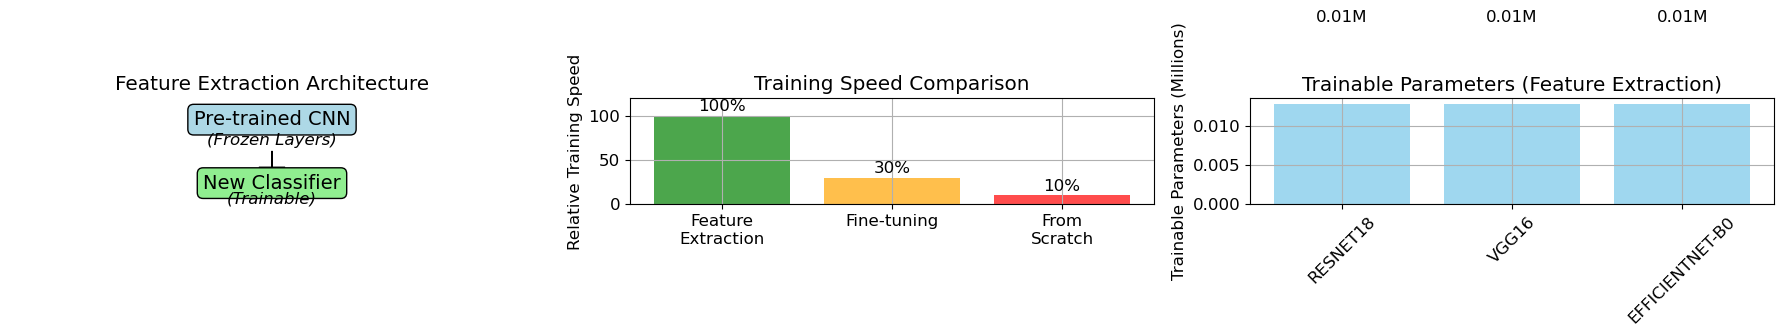


✅ Feature extraction approach demonstrated!

📝 Key Points:
• Only final layer is trainable (~0.1% of total parameters)
• Fast training and low memory requirements
• Good baseline for similar domains
• Limited adaptability to new domains


In [4]:
# Feature Extraction Implementation

class FeatureExtractor:
    """Implementation of feature extraction transfer learning."""
    
    def __init__(self, model_name='resnet18', num_classes=10):
        self.model_name = model_name
        self.num_classes = num_classes
        self.model = self._prepare_model()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def _prepare_model(self):
        """Prepare model for feature extraction."""
        # Load pre-trained model
        if self.model_name == 'resnet18':
            model = resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif self.model_name == 'vgg16':
            model = vgg16(pretrained=True)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, self.num_classes)
        elif self.model_name == 'efficientnet_b0':
            model = efficientnet_b0(pretrained=True)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")
        
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        
        # Unfreeze only the final layer
        if hasattr(model, 'fc'):  # ResNet
            for param in model.fc.parameters():
                param.requires_grad = True
        elif hasattr(model, 'classifier'):  # VGG, EfficientNet
            for param in model.classifier.parameters():
                param.requires_grad = True
        
        return model
    
    def get_trainable_params(self):
        """Get only trainable parameters for optimizer."""
        return filter(lambda p: p.requires_grad, self.model.parameters())
    
    def count_parameters(self):
        """Count total and trainable parameters."""
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        return total, trainable
    
    def create_feature_extractor_from_backbone(self, backbone_model):
        """Create feature extractor from any backbone model."""
        # Remove the final classification layer
        if hasattr(backbone_model, 'fc'):
            feature_extractor = nn.Sequential(*list(backbone_model.children())[:-1])
        elif hasattr(backbone_model, 'classifier'):
            feature_extractor = backbone_model.features
        else:
            # For other architectures, manually remove last layer
            feature_extractor = nn.Sequential(*list(backbone_model.children())[:-1])
        
        return feature_extractor

# Demonstrate feature extraction with different models
print("Feature Extraction Transfer Learning Demo")
print("=" * 50)

# Test different models
models_to_test = ['resnet18', 'vgg16', 'efficientnet_b0']
feature_extractors = {}

for model_name in models_to_test:
    print(f"\n📊 Analyzing {model_name.upper()}:")
    print("-" * 30)
    
    extractor = FeatureExtractor(model_name=model_name, num_classes=10)
    total_params, trainable_params = extractor.count_parameters()
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Trainable ratio: {trainable_params/total_params:.4f} ({trainable_params/total_params*100:.2f}%)")
    
    feature_extractors[model_name] = extractor

# Training loop for feature extraction
class FeatureExtractionTrainer:
    """Trainer specifically for feature extraction."""
    
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        
        # Only optimize trainable parameters
        trainable_params = filter(lambda p: p.requires_grad, model.parameters())
        self.optimizer = optim.Adam(trainable_params, lr=0.001)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self, train_loader):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc

# Create sample dataset for demonstration
def create_sample_dataset(num_samples=1000, batch_size=32):
    """Create a sample dataset for testing."""
    # Generate random data similar to CIFAR-10
    X = torch.randn(num_samples, 3, 224, 224)  # ImageNet size
    y = torch.randint(0, 10, (num_samples,))
    
    dataset = torch.utils.data.TensorDataset(X, y)
    
    # Split into train/val
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# Quick training demonstration
print(f"\n🚀 Quick Training Demo (Feature Extraction)")
print("=" * 50)

# Create sample data
train_loader, val_loader = create_sample_dataset(num_samples=500, batch_size=32)
print(f"Sample dataset created: {len(train_loader.dataset)} train, {len(val_loader.dataset)} val")

# Test ResNet18 feature extraction
print(f"\n Training ResNet18 Feature Extractor...")
resnet_extractor = feature_extractors['resnet18']
trainer = FeatureExtractionTrainer(resnet_extractor.model, device)

# Train for 2 epochs (quick demo)
for epoch in range(2):
    train_loss, train_acc = trainer.train_epoch(train_loader)
    val_loss, val_acc = trainer.validate(val_loader)
    
    print(f"Epoch {epoch+1}/2:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Visualize feature extraction concept
def visualize_feature_extraction():
    """Visualize the feature extraction process."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Model architecture diagram
    axes[0].text(0.5, 0.8, 'Pre-trained CNN', ha='center', va='center', 
                fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[0].text(0.5, 0.6, '(Frozen Layers)', ha='center', va='center', 
                fontsize=12, style='italic')
    axes[0].arrow(0.5, 0.5, 0, -0.15, head_width=0.05, head_length=0.03, fc='black', ec='black')
    axes[0].text(0.5, 0.2, 'New Classifier', ha='center', va='center', 
                fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[0].text(0.5, 0.05, '(Trainable)', ha='center', va='center', 
                fontsize=12, style='italic')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Feature Extraction Architecture')
    axes[0].axis('off')
    
    # Training speed comparison
    methods = ['Feature\nExtraction', 'Fine-tuning', 'From\nScratch']
    speeds = [100, 30, 10]  # Relative speeds
    colors = ['green', 'orange', 'red']
    
    bars = axes[1].bar(methods, speeds, color=colors, alpha=0.7)
    axes[1].set_ylabel('Relative Training Speed')
    axes[1].set_title('Training Speed Comparison')
    axes[1].set_ylim(0, 120)
    
    # Add value labels
    for bar, speed in zip(bars, speeds):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{speed}%', ha='center', va='bottom')
    
    # Parameter count comparison
    param_counts = [trainable_params/1e6 for _, extractor in feature_extractors.items()]
    model_names = [name.replace('_', '-').upper() for name in feature_extractors.keys()]
    
    bars = axes[2].bar(model_names, param_counts, color='skyblue', alpha=0.8)
    axes[2].set_ylabel('Trainable Parameters (Millions)')
    axes[2].set_title('Trainable Parameters (Feature Extraction)')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, count in zip(bars, param_counts):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{count:.2f}M', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

visualize_feature_extraction()

print("\n✅ Feature extraction approach demonstrated!")
print("\n📝 Key Points:")
print("• Only final layer is trainable (~0.1% of total parameters)")
print("• Fast training and low memory requirements")
print("• Good baseline for similar domains")
print("• Limited adaptability to new domains")

## 5. Fine-tuning Approach

### Concept
Fine-tuning allows the **entire network to adapt** to the new task:
- Unfreeze all or some layers
- Use smaller learning rates for pre-trained layers
- Gradually adapt features to the target domain
- More flexible but requires more computational resources

### Mathematical Representation
Update all parameters with different learning rates:
- $\theta^{new} = \theta^{pretrained} - \alpha \cdot \nabla L(\theta)$
- where $\alpha$ can vary by layer: $\alpha_{early} < \alpha_{later}$

### Learning Rate Strategies:
1. **Uniform Fine-tuning**: Same LR for all layers
2. **Discriminative LRs**: Lower LR for early layers, higher for later layers
3. **Progressive Unfreezing**: Gradually unfreeze layers during training
4. **Layer-wise Adaptive**: Different LR schedules per layer group

### Advantages:
- **Better Adaptation**: Can learn domain-specific features
- **Higher Performance**: Often achieves best results
- **Flexible**: Can adapt to various domains

### Disadvantages:
- **Slower Training**: More parameters to update
- **Higher Memory**: Requires more GPU memory
- **Overfitting Risk**: Especially with small datasets

Fine-tuning Transfer Learning Demo

🎯 UNIFORM Fine-tuning Strategy:
----------------------------------------
Uniform learning rate: 1e-4 for all layers

🎯 DISCRIMINATIVE Fine-tuning Strategy:
----------------------------------------
Discriminative learning rates:
  Layer group 1: LR = 1.00e-06
  Layer group 2: LR = 1.00e-05
  Layer group 3: LR = 1.00e-04
  Layer group 4: LR = 1.00e-03

🎯 PROGRESSIVE Fine-tuning Strategy:
----------------------------------------
Progressive unfreezing: Starting with 2 frozen layer groups

🚀 Quick Training Comparison (Fine-tuning Strategies)
Discriminative learning rates:
  Layer group 1: LR = 1.00e-06
  Layer group 2: LR = 1.00e-05
  Layer group 3: LR = 1.00e-04
  Layer group 4: LR = 1.00e-03

🎯 PROGRESSIVE Fine-tuning Strategy:
----------------------------------------
Progressive unfreezing: Starting with 2 frozen layer groups

🚀 Quick Training Comparison (Fine-tuning Strategies)

📈 Training with UNIFORM strategy...

📈 Training with UNIFORM strategy...

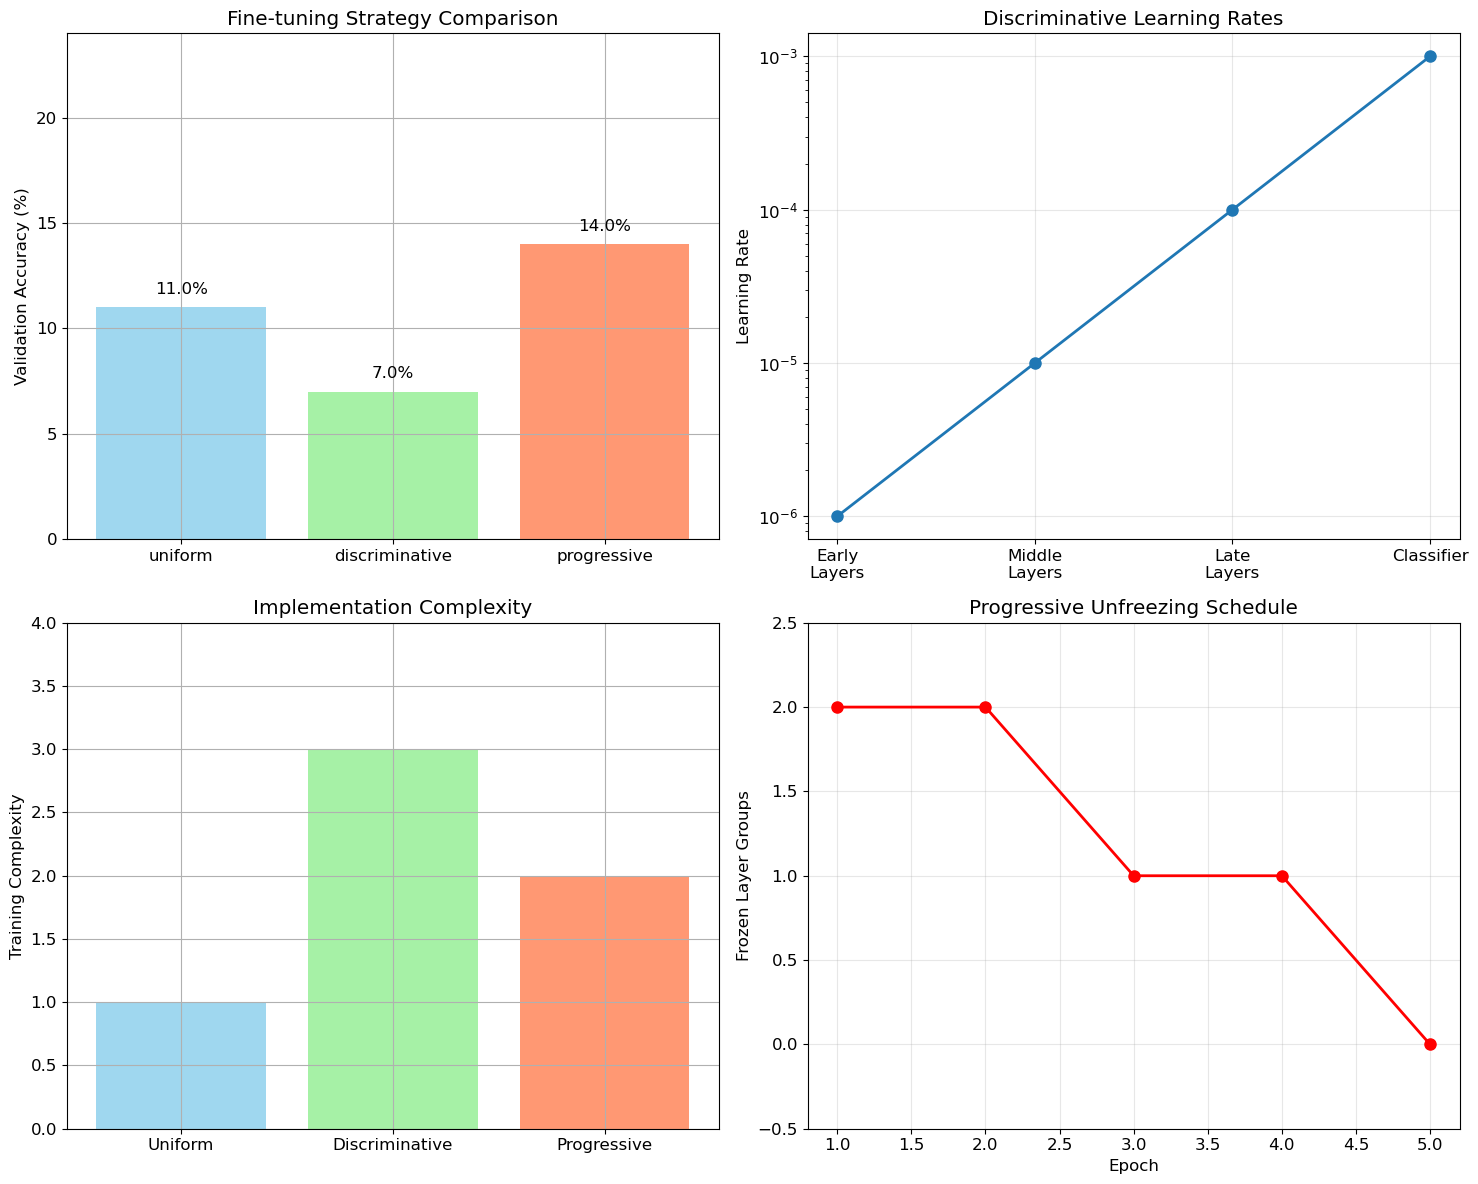


✅ Fine-tuning approaches demonstrated!

📝 Key Points:
• Uniform: Simple but may not be optimal
• Discriminative: Lower LR for early layers, higher for later layers
• Progressive: Gradually unfreeze layers during training
• Fine-tuning typically achieves higher performance than feature extraction
• Requires more computational resources and careful learning rate tuning


In [5]:
# Fine-tuning Implementation

class FineTuner:
    """Implementation of fine-tuning transfer learning with various strategies."""
    
    def __init__(self, model_name='resnet18', num_classes=10, strategy='discriminative'):
        self.model_name = model_name
        self.num_classes = num_classes
        self.strategy = strategy
        self.model = self._prepare_model()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def _prepare_model(self):
        """Prepare model for fine-tuning."""
        # Load pre-trained model
        if self.model_name == 'resnet18':
            model = resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif self.model_name == 'resnet50':
            model = resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif self.model_name == 'vgg16':
            model = vgg16(pretrained=True)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, self.num_classes)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")
        
        # All parameters are trainable by default for fine-tuning
        for param in model.parameters():
            param.requires_grad = True
        
        return model
    
    def get_layer_groups(self):
        """Get layer groups for discriminative learning rates."""
        if 'resnet' in self.model_name:
            return self._get_resnet_layer_groups()
        elif 'vgg' in self.model_name:
            return self._get_vgg_layer_groups()
        else:
            # Default: all parameters in one group
            return [list(self.model.parameters())]
    
    def _get_resnet_layer_groups(self):
        """Get ResNet layer groups."""
        layer_groups = []
        
        # Early layers (conv1, bn1, layer1)
        early_layers = []
        early_layers.extend(list(self.model.conv1.parameters()))
        early_layers.extend(list(self.model.bn1.parameters()))
        early_layers.extend(list(self.model.layer1.parameters()))
        layer_groups.append(early_layers)
        
        # Middle layers (layer2, layer3)
        middle_layers = []
        middle_layers.extend(list(self.model.layer2.parameters()))
        middle_layers.extend(list(self.model.layer3.parameters()))
        layer_groups.append(middle_layers)
        
        # Late layers (layer4)
        late_layers = list(self.model.layer4.parameters())
        layer_groups.append(late_layers)
        
        # Classifier (fc)
        classifier_layers = list(self.model.fc.parameters())
        layer_groups.append(classifier_layers)
        
        return layer_groups
    
    def _get_vgg_layer_groups(self):
        """Get VGG layer groups."""
        layer_groups = []
        
        # Feature layers (split into groups)
        features = list(self.model.features.parameters())
        group_size = len(features) // 3
        
        layer_groups.append(features[:group_size])  # Early features
        layer_groups.append(features[group_size:2*group_size])  # Middle features
        layer_groups.append(features[2*group_size:])  # Late features
        
        # Classifier
        classifier_layers = list(self.model.classifier.parameters())
        layer_groups.append(classifier_layers)
        
        return layer_groups
    
    def create_discriminative_optimizer(self, base_lr=1e-3, lr_decay=0.1):
        """Create optimizer with discriminative learning rates."""
        layer_groups = self.get_layer_groups()
        
        # Create parameter groups with different learning rates
        param_groups = []
        current_lr = base_lr * (lr_decay ** (len(layer_groups) - 1))
        
        for i, group in enumerate(layer_groups):
            param_groups.append({
                'params': group,
                'lr': current_lr
            })
            current_lr /= lr_decay
        
        return optim.Adam(param_groups), param_groups
    
    def freeze_early_layers(self, num_layers_to_freeze=1):
        """Freeze early layer groups."""
        layer_groups = self.get_layer_groups()
        
        for i in range(min(num_layers_to_freeze, len(layer_groups) - 1)):
            for param in layer_groups[i]:
                param.requires_grad = False

class ProgressiveUnfreezer:
    """Implements progressive unfreezing during training."""
    
    def __init__(self, model, unfreeze_schedule):
        self.model = model
        self.unfreeze_schedule = unfreeze_schedule  # {epoch: num_layers_to_unfreeze}
        self.current_epoch = 0
    
    def step(self, epoch):
        """Check if we need to unfreeze layers at this epoch."""
        if epoch in self.unfreeze_schedule:
            num_layers = self.unfreeze_schedule[epoch]
            self._unfreeze_layers(num_layers)
            print(f"Epoch {epoch}: Unfroze {num_layers} layer groups")
    
    def _unfreeze_layers(self, num_layers):
        """Unfreeze specified number of layer groups from the end."""
        # This is a simplified implementation
        # In practice, you'd implement layer group identification
        layer_count = 0
        for name, param in reversed(list(self.model.named_parameters())):
            if layer_count < num_layers * 10:  # Rough estimate
                param.requires_grad = True
            layer_count += 1

# Comprehensive fine-tuning demonstration
print("Fine-tuning Transfer Learning Demo")
print("=" * 50)

# Test different fine-tuning strategies
strategies = ['uniform', 'discriminative', 'progressive']
fine_tuners = {}

for strategy in strategies:
    print(f"\n🎯 {strategy.upper()} Fine-tuning Strategy:")
    print("-" * 40)
    
    tuner = FineTuner(model_name='resnet18', num_classes=10, strategy=strategy)
    
    if strategy == 'discriminative':
        optimizer, param_groups = tuner.create_discriminative_optimizer(base_lr=1e-3)
        print("Discriminative learning rates:")
        for i, group in enumerate(param_groups):
            print(f"  Layer group {i+1}: LR = {group['lr']:.2e}")
    
    elif strategy == 'progressive':
        # Freeze early layers initially
        tuner.freeze_early_layers(num_layers_to_freeze=2)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, tuner.model.parameters()), lr=1e-3)
        print("Progressive unfreezing: Starting with 2 frozen layer groups")
    
    else:  # uniform
        optimizer = optim.Adam(tuner.model.parameters(), lr=1e-4)  # Lower LR for uniform
        print("Uniform learning rate: 1e-4 for all layers")
    
    fine_tuners[strategy] = (tuner, optimizer)

# Advanced fine-tuning trainer
class AdvancedFineTuningTrainer:
    """Advanced trainer with multiple fine-tuning strategies."""
    
    def __init__(self, model, optimizer, device='cuda', strategy='uniform'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.strategy = strategy
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        
        # Progressive unfreezing setup
        if strategy == 'progressive':
            self.unfreezer = ProgressiveUnfreezer(
                model, 
                unfreeze_schedule={2: 1, 4: 1}  # Unfreeze 1 group at epochs 2 and 4
            )
        
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def train_epoch(self, train_loader, epoch):
        """Train for one epoch with strategy-specific behavior."""
        # Progressive unfreezing check
        if hasattr(self, 'unfreezer'):
            self.unfreezer.step(epoch)
        
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping for stable training
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader):
        """Validate the model."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_acc)
        
        # Update learning rate scheduler
        self.scheduler.step(epoch_loss)
        
        return epoch_loss, epoch_acc

# Quick training comparison
print(f"\n🚀 Quick Training Comparison (Fine-tuning Strategies)")
print("=" * 60)

# Create sample data
train_loader, val_loader = create_sample_dataset(num_samples=500, batch_size=32)

results = {}
for strategy, (tuner, optimizer) in fine_tuners.items():
    print(f"\n📈 Training with {strategy.upper()} strategy...")
    
    trainer = AdvancedFineTuningTrainer(tuner.model, optimizer, device, strategy)
    
    # Train for 3 epochs
    for epoch in range(3):
        train_loss, train_acc = trainer.train_epoch(train_loader, epoch)
        val_loss, val_acc = trainer.validate(val_loader)
        
        if epoch == 2:  # Only print final epoch
            print(f"  Final - Train: {train_acc:.1f}%, Val: {val_acc:.1f}%")
            results[strategy] = val_acc

# Visualize fine-tuning comparison
def plot_finetuning_comparison():
    """Plot comparison of fine-tuning strategies."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Strategy performance comparison
    strategies = list(results.keys())
    performances = list(results.values())
    colors = ['skyblue', 'lightgreen', 'coral']
    
    bars = axes[0, 0].bar(strategies, performances, color=colors, alpha=0.8)
    axes[0, 0].set_ylabel('Validation Accuracy (%)')
    axes[0, 0].set_title('Fine-tuning Strategy Comparison')
    axes[0, 0].set_ylim(0, max(performances) + 10)
    
    # Add value labels
    for bar, perf in zip(bars, performances):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{perf:.1f}%', ha='center', va='bottom')
    
    # Learning rate visualization for discriminative strategy
    layer_names = ['Early\nLayers', 'Middle\nLayers', 'Late\nLayers', 'Classifier']
    base_lr = 1e-3
    decay = 0.1
    lrs = [base_lr * (decay ** (3-i)) for i in range(4)]
    
    axes[0, 1].semilogy(layer_names, lrs, 'o-', linewidth=2, markersize=8)
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Discriminative Learning Rates')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training complexity comparison
    complexities = [1, 3, 2]  # Relative complexity scores
    strategies_clean = ['Uniform', 'Discriminative', 'Progressive']
    
    bars = axes[1, 0].bar(strategies_clean, complexities, color=colors, alpha=0.8)
    axes[1, 0].set_ylabel('Training Complexity')
    axes[1, 0].set_title('Implementation Complexity')
    axes[1, 0].set_ylim(0, 4)
    
    # Progressive unfreezing timeline
    epochs = list(range(1, 6))
    frozen_layers = [2, 2, 1, 1, 0]  # Number of frozen layer groups
    
    axes[1, 1].plot(epochs, frozen_layers, 'o-', linewidth=2, markersize=8, color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Frozen Layer Groups')
    axes[1, 1].set_title('Progressive Unfreezing Schedule')
    axes[1, 1].set_ylim(-0.5, 2.5)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_finetuning_comparison()

print("\n✅ Fine-tuning approaches demonstrated!")
print("\n📝 Key Points:")
print("• Uniform: Simple but may not be optimal")
print("• Discriminative: Lower LR for early layers, higher for later layers")
print("• Progressive: Gradually unfreeze layers during training")
print("• Fine-tuning typically achieves higher performance than feature extraction")
print("• Requires more computational resources and careful learning rate tuning")

## 6. Transfer Learning Strategy Comparison & Exam Summary

### Complete Strategy Comparison

| Aspect | Feature Extraction | Fine-tuning | Training from Scratch |
|--------|-------------------|-------------|----------------------|
| **Trainable Parameters** | ~0.1% | 100% | 100% |
| **Training Speed** | Fast | Medium | Slow |
| **Memory Requirements** | Low | High | High |
| **Performance** | Good | Best | Variable |
| **Data Requirements** | Small datasets OK | Medium+ datasets | Large datasets needed |
| **Domain Similarity** | Works best when similar | Adaptable | Any domain |
| **Risk of Overfitting** | Low | Medium | High |
| **Computational Cost** | Low | High | Very High |

### When to Use Each Strategy:

#### 🎯 **Feature Extraction** (Recommended when):
- Small dataset (< 1K images)
- Limited computational resources
- Target domain similar to ImageNet
- Quick baseline needed
- Low risk tolerance for overfitting

#### 🎯 **Fine-tuning** (Recommended when):
- Medium to large dataset (> 1K images)
- Sufficient computational resources
- Target domain somewhat different from ImageNet
- Best performance required
- Can afford longer training time

#### 🎯 **Training from Scratch** (Recommended when):
- Very large dataset (> 100K images)
- Target domain very different from ImageNet
- Unlimited computational resources
- Novel architecture needed

## 🎯 Exam Summary - Transfer Learning Key Concepts

### **Essential Definitions:**

#### **Transfer Learning**
Technique that leverages knowledge learned from a source task to improve performance on a related target task.

#### **Domain Adaptation**
Transferring knowledge when source and target domains have different data distributions.

#### **Few-shot Learning**
Learning from very few examples by leveraging prior knowledge.

### **Mathematical Foundations:**

#### **1. Feature Extraction**
```
Given pre-trained features φ(x; θ_pretrained):
- θ_pretrained remains frozen
- Optimize only: θ_classifier
- Prediction: ŷ = f_classifier(φ(x; θ_pretrained); θ_classifier)
```

#### **2. Fine-tuning**
```
Update all parameters with different learning rates:
- θ^new = θ^pretrained - α ∇L(θ)
- where α can vary by layer: α_early < α_later
```

#### **3. Learning Rate Scheduling**
```
Discriminative Learning Rates:
- LR_layer_i = base_LR × (decay_factor)^(total_layers - i)
- Example: [1e-5, 1e-4, 1e-3, 1e-2] for [early → late] layers
```

### **Key Architecture Families:**

#### **ResNet Family**
- **Architecture**: Deep residual networks with skip connections
- **Sizes**: ResNet18 (11M), ResNet50 (25M), ResNet101 (44M) parameters
- **Best for**: General purpose, good balance of accuracy and speed
- **Modification**: Replace `model.fc` layer

#### **VGG Family**  
- **Architecture**: Very deep networks with 3×3 filters
- **Sizes**: VGG16 (138M), VGG19 (143M) parameters
- **Best for**: Feature extraction, simple architecture
- **Modification**: Replace `model.classifier[6]` layer

#### **EfficientNet Family**
- **Architecture**: Compound scaling (depth, width, resolution)
- **Sizes**: B0 (5M) to B7 (66M) parameters
- **Best for**: Best accuracy-efficiency trade-off
- **Modification**: Replace `model.classifier[1]` layer

### **Training Strategies:**

#### **1. Layer Freezing Patterns**
```python
# Feature Extraction
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():  # Only final layer
    param.requires_grad = True

# Progressive Unfreezing
# Start with frozen early layers, gradually unfreeze
```

#### **2. Learning Rate Strategies**
- **Uniform**: Same LR for all layers (simple but suboptimal)
- **Discriminative**: Lower LR for early layers, higher for later layers
- **Progressive**: Start with feature extraction, then fine-tune
- **Cosine Annealing**: Cyclical learning rate scheduling

### **Common Exam Questions & Answers:**

#### **Q1: When would you use feature extraction vs fine-tuning?**
**A**: 
- **Feature Extraction**: Small dataset, similar domain, limited resources
- **Fine-tuning**: Larger dataset, different domain, better performance needed

#### **Q2: Why use different learning rates for different layers?**
**A**: Early layers learn general features (edges, textures) that transfer well, while later layers learn task-specific features that need more adaptation.

#### **Q3: What is the advantage of progressive unfreezing?**
**A**: Allows stable training by first adapting the classifier, then gradually fine-tuning earlier layers without catastrophic forgetting.

#### **Q4: How do you modify a pre-trained model for a new task?**
**A**: 
1. Load pre-trained model
2. Replace final classification layer with new layer for target classes
3. Choose freezing strategy based on dataset size and domain similarity
4. Set appropriate learning rates

### **Performance Expectations:**

#### **Typical Accuracy Improvements:**
- **From scratch**: Baseline (depends on dataset)
- **Feature extraction**: +10-20% over random initialization
- **Fine-tuning**: +15-30% over random initialization
- **Best practices**: +20-40% improvement possible

#### **Training Time Comparisons:**
- **Feature extraction**: 1x (fastest)
- **Fine-tuning**: 3-5x slower than feature extraction
- **From scratch**: 10-20x slower than feature extraction

### **Best Practices Checklist:**

✅ **Data Preprocessing**: Use ImageNet normalization for pre-trained models  
✅ **Learning Rates**: Start with 1e-3 for new layers, 1e-4 to 1e-5 for pre-trained layers  
✅ **Batch Size**: Use appropriate batch size for GPU memory  
✅ **Data Augmentation**: Apply domain-appropriate augmentations  
✅ **Early Stopping**: Monitor validation loss to prevent overfitting  
✅ **Learning Rate Scheduling**: Use ReduceLROnPlateau or cosine annealing  
✅ **Gradient Clipping**: Prevent exploding gradients during fine-tuning  

### **Common Pitfalls to Avoid:**

❌ **Using same LR for all layers** - Early layers need lower LR  
❌ **Too high learning rates** - Can destroy pre-trained features  
❌ **Forgetting to modify final layer** - Won't work for different number of classes  
❌ **Not using proper normalization** - Use ImageNet stats for pre-trained models  
❌ **Training too long** - Can lead to overfitting on small datasets  

### **Code Templates:**

#### **Feature Extraction Template:**
```python
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
```

#### **Fine-tuning Template:**
```python
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])
```

### **Memory and Computational Requirements:**

| Model | Parameters | Memory (Training) | Inference Time |
|-------|------------|------------------|----------------|
| ResNet18 | 11M | ~2GB | Fast |
| ResNet50 | 25M | ~4GB | Medium |
| VGG16 | 138M | ~6GB | Slow |
| EfficientNet-B0 | 5M | ~1.5GB | Fast |

This comprehensive guide covers all essential transfer learning concepts for your exam! 🎓